In [1]:
#Image Captioning
#Generating Caption for Images

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [3]:
#Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [23]:
captions=readTextFile("flickr_dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions=captions.split('\n') [:-1]

In [24]:
print(len(captions))

40460


In [26]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [40]:
first,second=captions[0].split('\t')
print(first.split(".")[0])
print(second)


1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [41]:
#Create a dictionary to map each Image with the list of captions it has

In [43]:
descriptions={}
for x in captions:
    first,second=x.split('\t')
    img_name=first.split(".")[0]
    
    #check if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
        
    descriptions[img_name].append(second)

In [44]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

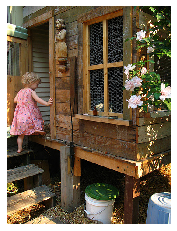

In [47]:
IMG_PATH="flickr_dataset/Flickr_Data/Flickr_Data/Images/"
import cv2
import matplotlib.pyplot as plt

img=cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [48]:
#Data Cleaning

In [67]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence =[s for s in sentence if len(s)>1]
    sentence= " ".join(sentence)
    
    return sentence

In [68]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [69]:
#Clean all the Captions

In [74]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])

In [72]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [75]:
#Write the data into a text file
with open("descriptions_1.txt","w")as f:
    f.write(str(descriptions))

In [76]:
#Vocabulary

In [96]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [97]:
print(type(descriptions))

<class 'dict'>


In [98]:
#Vocab

vocab=set()
for key in descriptions.keys():
    [ vocab.update(sentence.split())for sentence in descriptions[key]]
    
print("Vocab Size : %d" %len(vocab))

Vocab Size : 8424


In [99]:
#Total number of words across all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d" %len(total_words))
    

Total Words 373837


In [101]:
import collections

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [102]:
#Sort this dictionary according to the freq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filter
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0]for x in sorted_freq_cnt]

In [103]:
print(len(total_words))

1845


In [104]:
#Prepare Train/Test Data
train_file_data=readTextFile("flickr_dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("flickr_dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [105]:
train=[ row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [106]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [107]:
#Prepare Description for the training data
#Tweak -Add <s> and <e> token to our trainig data
train_descriptions={}

for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq " + cap +" endseq"
        train_descriptions[img_id].append(cap_to_append)
    

In [108]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [109]:
#Transfer Learning
#Images-->features
#Text-->Features

In [110]:
#Image Feature Extraction


In [111]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

W0323 12:31:34.724915  7212 deprecation_wrapper.py:119] From c:\users\hp\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0323 12:31:35.223494  7212 deprecation_wrapper.py:119] From c:\users\hp\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0323 12:31:35.487998  7212 deprecation_wrapper.py:119] From c:\users\hp\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0323 12:31:35.814115  7212 deprecation_wrapper.py:119] From c:\users\hp\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0323 12:31:35.831077  7212 depre

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [112]:
model_new=Model(model.input,model.layers[-2].output)

In [113]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    #Normalisation
    img=preprocess_input(img)
    return img

In [114]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [115]:
encode_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154464, 0.17075905, 0.29276785, ..., 0.05094026, 0.3131964 ,
       0.8600726 ], dtype=float32)

In [116]:
start=time()
encoding_train={}
#image_id --> feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time Step %d" %ix)
    
end_t=time()
print("Total time Taken:",end_t-start)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Encoding in Progress Time Step 1000
Encoding in Progress Time Step 1100
Encoding in Progress Time Step 1200
Encoding in Progress Time Step 1300
Encoding in Progress Time Step 1400
Encoding in Progress Time Step 1500
Encoding in Progress Time Step 1600
Encoding in Progress Time Step 1700
Encoding in Progress Time Step 1800
Encoding in Progress Time Step 1900
Encoding in Progress Time Step 2000
Encoding in Progress Time Step 2100
Encoding in Progress Time Step 2200
Encoding in Progress Time Step 2300
Encoding in Progress Time Step 2400
Encoding in Progress Time Step 2500
Encoding in Progress Time Step 2600
Encoding in Progress Time Step 2700
Enco

In [117]:
!mkdir saved

In [118]:
#Store everything to the disk
with open("saved/encoding_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [119]:
start=time()
encoding_test={}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time Step %d "%ix)

end_t=time()
print("Total Time Taken(test) : ",end_t-start)

Test Encoding in Progress Time Step 0 
Test Encoding in Progress Time Step 100 
Test Encoding in Progress Time Step 200 
Test Encoding in Progress Time Step 300 
Test Encoding in Progress Time Step 400 
Test Encoding in Progress Time Step 500 
Test Encoding in Progress Time Step 600 
Test Encoding in Progress Time Step 700 
Test Encoding in Progress Time Step 800 
Test Encoding in Progress Time Step 900 
Total Time Taken(test) :  356.9430501461029


In [120]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [121]:
#Data PreProcessing for Captions

In [122]:
#vocab
len(total_words)

1845

In [123]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [129]:
print(word_to_idx["dog"])
print(idx_to_word[6])
print(len(idx_to_word))

6
dog
1845


In [130]:
#Two Special Words
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846

idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

vocab_size=len(word_to_idx)+1
print("Vocab Size %d"%vocab_size)

Vocab Size 1848


In [131]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
        
print(max_len)

35


In [132]:
#Data Loader(Generator)

In [136]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y=[],[],[]
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo=encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                #index 0 is reserved for padding
                for i in rang(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    #0 denote padding word
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y=[],[],[]
                    n=0
                
                    

In [137]:
#Word Embeddings

In [144]:
f=open("./saved/glove.6B.50d.txt",encoding='utf8')

In [145]:
embedding_index={}

for line in f :
    values=line.split()
    
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    
    

In [147]:
f.close()

In [148]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [149]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix

In [150]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [151]:
#Model Architecture

In [152]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)

W0323 19:00:58.384109  7212 deprecation.py:506] From c:\users\hp\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [154]:
#Captions as Input
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

W0323 19:04:16.265217  7212 deprecation.py:323] From c:\users\hp\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [155]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [156]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [157]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [158]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

W0323 19:06:50.877414  7212 deprecation_wrapper.py:119] From c:\users\hp\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [159]:
#Training Of Model

In [162]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)


In [168]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [171]:
model = load_model('./model_weights/model_9.h5')

In [172]:
#Predictions

In [173]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

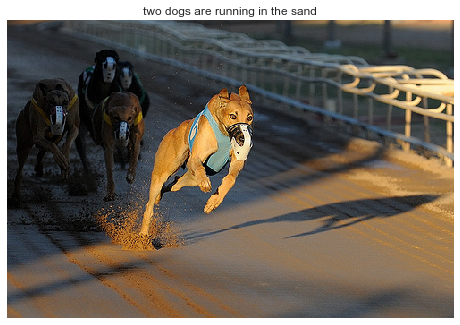

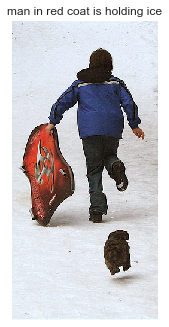

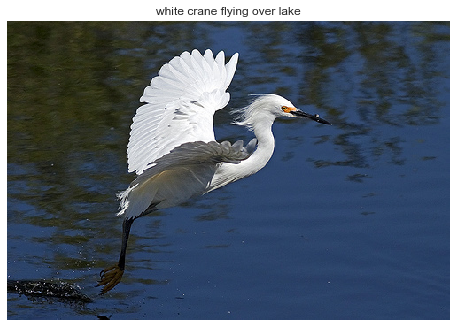

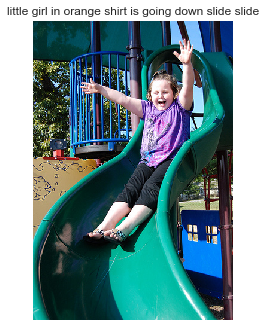

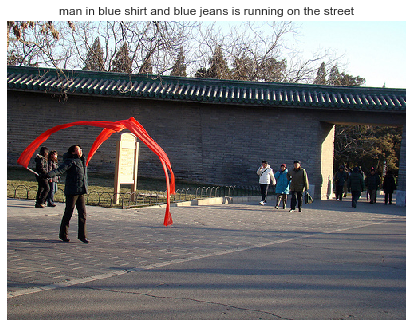

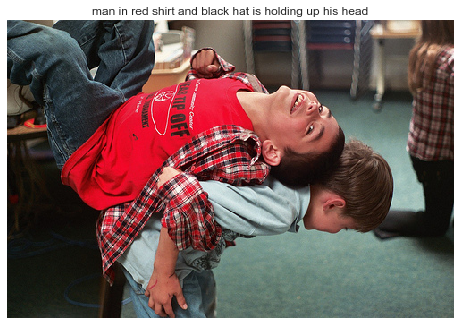

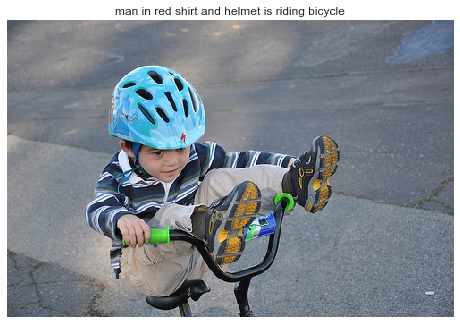

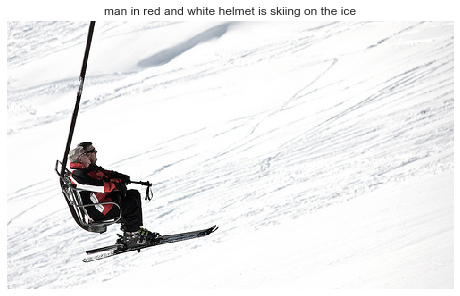

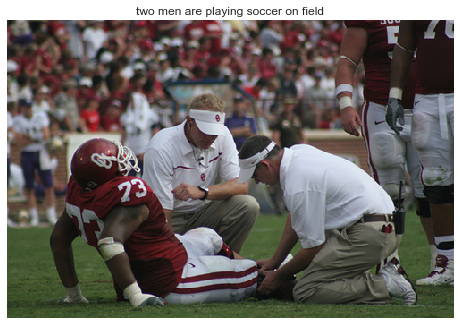

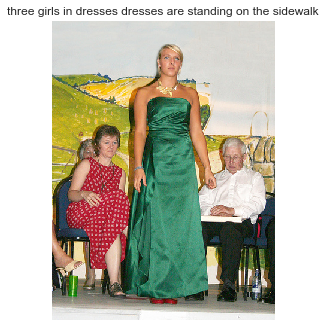

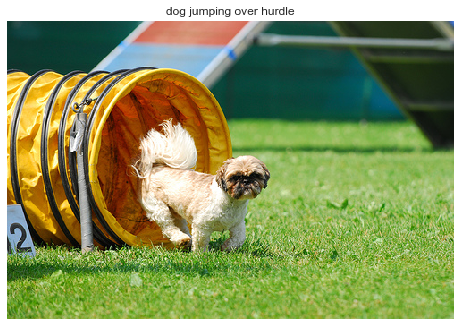

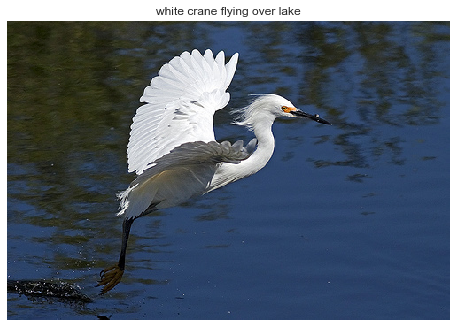

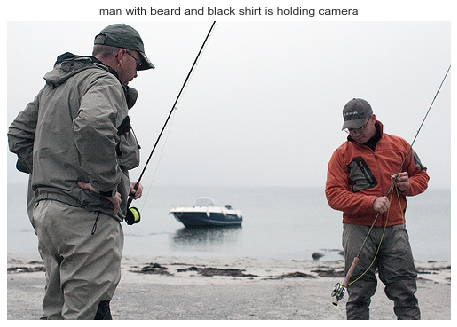

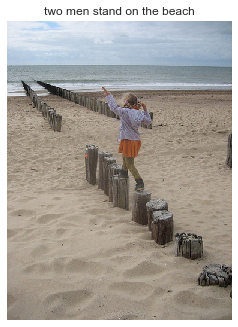

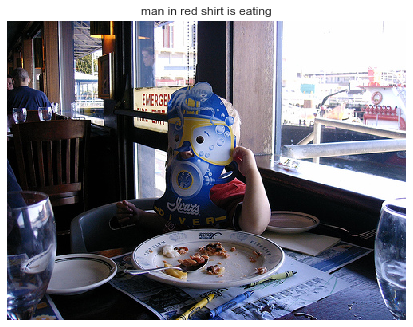

In [175]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
   
    i=plt.imread('flickr_dataset/Flickr_Data/Flickr_Data/Images/'+img_name+'.jpg')
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    